In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        if filename == "CarPrice_Assignment.csv":
            filepath = os.path.join(dirname, filename)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


/kaggle/input/car-price-prediction/CarPrice_Assignment.csv
/kaggle/input/car-price-prediction/Data Dictionary - carprices.xlsx


In [4]:
data = pd.read_csv(filepath)
print(data.shape)

(205, 26)


In [5]:
data.dtypes.value_counts()

object     10
int64       8
float64     8
Name: count, dtype: int64

In [7]:
mask = data.dtypes == object # 데이터의 타입이 스트링인 경우를 boolean으로 하여 마스크를 가져온다.
categorical_cols = data.columns[mask] # 데이터 타입이 스트링인 특징의 이름을 가져온다. 

In [8]:
# Determine how many extra columns would be created
num_ohc_cols = (data[categorical_cols] # 각각의 스트링 데이터에 대해서 
                .apply(lambda x: x.nunique()) # 스트링의 종류의 개수를 센다. 
                .sort_values(ascending=False)) # 데이터 특징의 이름에 따라서 정렬


# No need to encode if there is only one value
small_num_ohc_cols = num_ohc_cols.loc[num_ohc_cols>1]

# Number of one-hot columns is one less than the number of categories
small_num_ohc_cols -= 1

# This is 215 columns, assuming the original ones are dropped. 
# This is quite a few extra columns!
small_num_ohc_cols.sum()

175

In [10]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

In [11]:
# Copy of the data
data_ohc = data.copy()

# The encoders
le = LabelEncoder() # 저번에는 LabelBinarizer를 썼는데 이번에는 스트링 개수가 두 개 이상이니까 LabelEncoder. 각각의 스트링에 대해 숫자를 매칭시켜주는.
ohc = OneHotEncoder()

for col in num_ohc_cols.index:
    
    # Integer encode the string categories
    dat = le.fit_transform(data_ohc[col]).astype(int) #각 스트링 클래스마다 인코딩
    
    # Remove the original column from the dataframe
    data_ohc = data_ohc.drop(col, axis=1) 

    # One hot encode the data--this returns a sparse array
    new_dat = ohc.fit_transform(dat.reshape(-1,1))

    # Create unique column names
    n_cols = new_dat.shape[1]
    col_names = ['_'.join([col, str(x)]) for x in range(n_cols)]

    # Create the new dataframe
    new_df = pd.DataFrame(new_dat.toarray(), 
                          index=data_ohc.index, 
                          columns=col_names)

    # Append the new data to the dataframe
    data_ohc = pd.concat([data_ohc, new_df], axis=1)

# 나머지는 다 0이고 원하는 조건일 때만 1. 모든 각각의 특징에 대해서 one hot encoding 

In [12]:
# Column difference is as calculated above
data_ohc.shape[1] - data.shape[1]

# data_ohc: 숫자 형태 + 스트링 데이터는 one hot encoding된 . 

175

In [13]:
print(data.shape[1])

# Remove the string columns from the dataframe
data = data.drop(num_ohc_cols.index, axis=1)

print(data.shape[1])
# 26 - 10
# 16

# data 변수: 이제 숫자 형태만 있다. 

26
16


In [15]:
y_col = 'price'

# Split the data that is not one-hot encoded
feature_cols = [x for x in data.columns if x != y_col]
X_data = data[feature_cols]
y_data = data[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=42)
# 데이터를 받으면 데이터를 train과 test로 나눠준다. 

# Split the data that is one-hot encoded
feature_cols = [x for x in data_ohc.columns if x != y_col]
X_data_ohc = data_ohc[feature_cols]
y_data_ohc = data_ohc[y_col]

X_train_ohc, X_test_ohc, y_train_ohc, y_test_ohc = train_test_split(X_data_ohc, y_data_ohc, 
                                                    test_size=0.3, random_state=42)


# 두 방식의 성능을 비교해주는 거니까 random seed 같은 값으로 설정 42

In [16]:
(X_train_ohc.index == X_train.index).all()

True

In [17]:
LR = LinearRegression()

# Storage for error values
error_df = list()

# Data that have not been one-hot encoded
LR = LR.fit(X_train, y_train) # 학습
y_train_pred = LR.predict(X_train) # training data에 대해 pred
y_test_pred = LR.predict(X_test) # test data에 대해 pred

error_df.append(pd.Series({'train': mean_squared_error(y_train, y_train_pred), # pred 값과 실제 값을 비교해 오차율 계산
                           'test' : mean_squared_error(y_test,  y_test_pred)},
                           name='no enc'))

# Data that have been one-hot encoded
LR = LR.fit(X_train_ohc, y_train_ohc)
y_train_ohc_pred = LR.predict(X_train_ohc)
y_test_ohc_pred = LR.predict(X_test_ohc)

error_df.append(pd.Series({'train': mean_squared_error(y_train_ohc, y_train_ohc_pred),
                           'test' : mean_squared_error(y_test_ohc,  y_test_ohc_pred)},
                          name='one-hot enc'))

# Assemble the results
error_df = pd.concat(error_df, axis=1)
error_df

,no enc,one-hot enc
train,7.652381e+06,1.322405e+05
test,1.184365e+07,1.957470e+08


In [18]:
pd.options.mode.chained_assignment = None

In [19]:
scalers = {'standard': StandardScaler(), # 오버피팅 없애기 위해 정규화 수행. 데이터의 분포를 맞춰주는 것. 
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}

training_test_sets = {
    'not_encoded': (X_train, y_train, X_test, y_test),
    'one_hot_encoded': (X_train_ohc, y_train_ohc, X_test_ohc, y_test_ohc)}


# Get the list of float columns, and the float data
# so that we don't scale something we already scaled. 
# We're supposed to scale the original data each time
mask = X_train.dtypes == float # 스케일링 적용은 소수점 데이터를 대상으로 
float_columns = X_train.columns[mask]

# initialize model
LR = LinearRegression()

# iterate over all possible combinations and get the errors
errors = {}
for encoding_label, (_X_train, _y_train, _X_test, _y_test) in training_test_sets.items(): # 각각의 데이터에 따라서 
    for scaler_label, scaler in scalers.items(): # 각각의 scaler에 따라서 
        trainingset = _X_train.copy()  # copy because we dont want to scale this more than once.
        testset = _X_test.copy()
        trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns]) # Scaler를 학습시키고 데이터를 학습된 분포로 변환. 이때 꼭 training data만 사용해서 해야 한다. 
        # 분포 추출은 알고 있는 데이터에서 해야 하는 것이기 때문이다. 
        testset[float_columns] = scaler.transform(testset[float_columns]) # test set에 대해서는 transform만 진행. 
        LR.fit(trainingset, _y_train)
        predictions = LR.predict(testset)
        key = encoding_label + ' - ' + scaler_label + 'scaling'
        errors[key] = mean_squared_error(_y_test, predictions)

errors = pd.Series(errors)
print(errors.to_string())
print('-' * 80)
for key, error_val in errors.items():
    print(key, error_val)

not_encoded - standardscaling        1.184365e+07
not_encoded - minmaxscaling          1.184365e+07
not_encoded - maxabsscaling          1.184365e+07
one_hot_encoded - standardscaling    1.957470e+08
one_hot_encoded - minmaxscaling      1.957470e+08
one_hot_encoded - maxabsscaling      1.957470e+08
--------------------------------------------------------------------------------
not_encoded - standardscaling 11843650.222782087
not_encoded - minmaxscaling 11843650.222782264
not_encoded - maxabsscaling 11843650.222783502
one_hot_encoded - standardscaling 195746976.30444503
one_hot_encoded - minmaxscaling 195746976.3044043
one_hot_encoded - maxabsscaling 195746976.3028499


[Text(0.5, 0, 'truth'),
 Text(0, 0.5, 'Predictions'),
 Text(0.5, 1.0, 'Car price prediction vs Truth, using Linear Regression')]

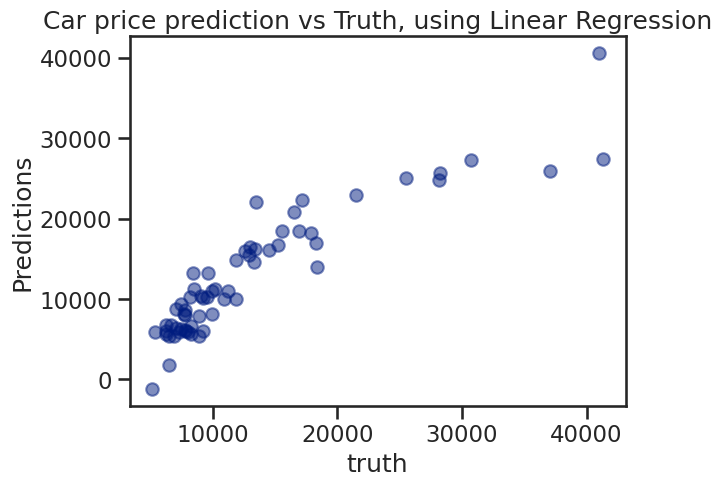

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_test_pred, alpha=.5)

ax.set(xlabel='truth', 
       ylabel='Predictions',
       title='Car price prediction vs Truth, using Linear Regression')